<a href="https://colab.research.google.com/github/frank22004/GenAI/blob/main/GenAI%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1 安裝套件

In [1]:
!pip install -U langchain langchain-community pypdf python-docx sentence-transformers faiss-cpu gradio openai wordcloud dash fuss fuzzywuzzy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 99.6 MB/s eta 0:00:00
   ━━━━━

安裝中文字體

In [2]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

--2025-06-02 15:51:53--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.214.139, 172.217.214.101, 172.217.214.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-02 15:51:53--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.201.132, 2607:f8b0:4001:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.201.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  64.0MB/s    in 0.3s    

2025-06-02 15

In [3]:
# 載入必要套件
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 文字雲
from wordcloud import WordCloud

import os
from openai import OpenAI
import gradio as gr

# 互動設計用
from ipywidgets import interact_manual

from google.colab import userdata

# 文件分析
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.schema import Document

# 模糊比對
from fuzzywuzzy import fuzz, process

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
from langchain.embeddings import HuggingFaceEmbeddings

class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

## 1.2. 設定LLM

  ### 1.2.1 設定API來自Llama 3-70b

In [5]:
api_key = userdata.get('Groq')
os.environ["OPENAI_API_KEY"] = api_key
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

### 1.2.2 設定OpenAI跟Prompt

In [6]:
client = OpenAI(
    base_url=base_url
)

system_prompt = "你是臨床心理與照護的專家，請根據患者書寫的日記。請分析當下情緒，並給予適當鼓勵。請務必用台灣的中文回應。"

1.2.3. Test

In [7]:
prompt = "今天的下午改變了我整個人生。醫生告訴我：「是乳癌，第二期。」我愣住了，什麼話都說不出來。那一瞬間，我的心跳變得好快，耳邊像嗡嗡作響，世界彷彿靜止。怎麼可能？我才三十八歲，身體一向健康，也沒有家族病史，怎麼會是我？我一直在想，是不是報告弄錯了？是不是只是良性腫瘤？但醫生的眼神很肯定，沒有空間懷疑。"


messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompt}
]

In [8]:
response = client.chat.completions.create(
    model=model,
    messages=messages
    )

print(response.choices[0].message.content)

親愛的病人，你今天經歷了人生中的大震撼，情感上受到很大的衝擊。從你的日記可以看出，你感到非常驚恐、震驚、不敢相信這個診斷結果。

首先，讓我告訴你，你的反應是非常正常的。任何人在面對這種突如其來的診斷結果時，都會感到震驚、恐懼、混亂的情緒。如果你覺得你的心跳變得很快，耳邊嗡嗡作響，這都是你的身體對於這個不良消息的自然反應。

其次，你開始自我懷疑，「怎麼可能？」「我才三十八歲」，這都是正常的思想反應。你開始思考這個診斷結果是否正確，是否有錯誤的地方，這都是你在嘗試理解這個診斷結果的過程。

最後，醫生的眼神很肯定，沒有空間懷疑，這意味著你需要面對這個診斷結果，並且開始思考今後的治療計畫。

在這個時刻，我想告訴你，你不是一个人。你有家人、朋友和專業醫療團隊支持你。同時，你也可以尋求心理輔導和社工服務，以取得更多的支持和資源。

請記住，你不是你的疾病。你是一個有價值、有尊嚴的人，你的生命仍然充滿希望和可能性。這時刻，你需要好好照顧自己，並且開始思考如何面對這個新的挑戰。


## 1.3 讀取NTUSD中文正負向詞彙字典

台灣大學自然語言處理實驗室(NTU Natural Language Processing Laboratory)[陳信希教授團隊](https://nlg.csie.ntu.edu.tw/advisor.php)，利用Jieba斷詞和Naive Bayes分類器所建立中文情緒辭典(NTUSD)，其涵蓋8277個負面情緒詞跟2810個正面情緒詞。

故下載Github的NTUSD專案

In [9]:
!git clone https://github.com/sweslo17/chinese_sentiment.git

Cloning into 'chinese_sentiment'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74 (from 1)
Receiving objects: 100% (74/74), 140.46 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (24/24), done.


### 1.3.1. 將txt轉成List

In [10]:
postiveEmo = TextLoader('/content/chinese_sentiment/dict/ntusd-positive.txt')
negativeEmo = TextLoader('/content/chinese_sentiment/dict/ntusd-negative.txt')

In [11]:
postiveEmo = postiveEmo.load()
negativeEmo = negativeEmo.load()

In [12]:
postiveEmo = postiveEmo[0].page_content.split('\n')
negativeEmo = negativeEmo[0].page_content.split('\n')

In [13]:
postiveEmo = [i.split('\t')[0] for i in postiveEmo]
negativeEmo = [i.split('\t')[0] for i in negativeEmo]

#### 顯示正面情緒詞

In [14]:
def print_pos(n=0):
    print(postiveEmo[n])

interact_manual(print_pos,n=(0,len(postiveEmo)-1))

interactive(children=(IntSlider(value=0, description='n', max=2809), Button(description='Run Interact', style=…

<function __main__.print_pos(n=0)>

#### 顯示負面情緒詞

In [15]:
def print_neg(n=0):
    print(negativeEmo[n])

interact_manual(print_neg,n=(0,len(negativeEmo)-1))

interactive(children=(IntSlider(value=0, description='n', max=8277), Button(description='Run Interact', style=…

<function __main__.print_neg(n=0)>

### 1.3.2. 建立正面情緒向量資料庫

In [16]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")

# Create Document objects from the list of positive emotion strings
positive_documents = [Document(page_content=emo) for emo in postiveEmo]

# Pass the list of Document objects to FAISS.from_documents
vectorstore_pos = FAISS.from_documents(positive_documents, embedding_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

嘗試RAG

In [17]:
retriever_pos = vectorstore_pos.as_retriever()

AI agent回答的內容

In [18]:
docs = retriever_pos.get_relevant_documents(response.choices[0].message.content)
docs

<ipython-input-18-b0bb859ca28d>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever_pos.get_relevant_documents(response.choices[0].message.content)


[Document(id='71b1607a-0944-4662-b154-42aea9f09416', metadata={}, page_content='深切注意的'),
 Document(id='f81038e7-526d-4d74-b851-89a0ce88d6ba', metadata={}, page_content='深切注意'),
 Document(id='49fe4a65-9f00-44f8-a32c-0358225ed69c', metadata={}, page_content='神志正常的'),
 Document(id='782e927b-0005-4dd5-b369-a5961bd632ba', metadata={}, page_content='有責任心的')]

模擬的患者日記

In [19]:
docs_pa = retriever_pos.get_relevant_documents(prompt)
docs_pa

[Document(id='4002acd0-af3c-4ef4-8500-82fa931358ba', metadata={}, page_content='正常'),
 Document(id='8caaee50-8532-4e54-9276-683c63b87c55', metadata={}, page_content='痛快'),
 Document(id='617d999b-00c3-4f8b-8ad3-b52c4b261059', metadata={}, page_content='心情愉快'),
 Document(id='efce9713-489e-477b-8978-a06182793609', metadata={}, page_content='心情愉快的')]

### 1.3.3 建立負面情緒向量資料庫

In [20]:
# Create Document objects from the list of positive emotion strings
negative_documents = [Document(page_content=emo) for emo in negativeEmo]

# Pass the list of Document objects to FAISS.from_documents
vectorstore_neg = FAISS.from_documents(negative_documents, embedding_model)

嘗試RAG

In [21]:
retriever_neg = vectorstore_neg.as_retriever()

AI agent的回答

In [22]:
doc_neg = retriever_neg.get_relevant_documents(response.choices[0].message.content)
doc_neg

[Document(id='60cc9508-d26f-4d05-9c25-24c53168c71d', metadata={}, page_content='心神不安'),
 Document(id='360f0415-1c44-46b0-b89d-d7adb8385207', metadata={}, page_content='心神不安的'),
 Document(id='aceef80c-2eda-4bbf-9c22-f6f3d8e2daf9', metadata={}, page_content='心疼'),
 Document(id='df28997a-449e-4564-ae0e-748a2106a420', metadata={}, page_content='感到極度痛苦')]

模擬的患者日記

In [23]:
doc_neg_pa = retriever_neg.get_relevant_documents(prompt)
doc_neg_pa

[Document(id='aceef80c-2eda-4bbf-9c22-f6f3d8e2daf9', metadata={}, page_content='心疼'),
 Document(id='473b68a4-db31-4078-983a-ab6a5c4d37a6', metadata={}, page_content='心痛'),
 Document(id='360f0415-1c44-46b0-b89d-d7adb8385207', metadata={}, page_content='心神不安的'),
 Document(id='7da7aacc-6e18-4206-a01e-7843f818b5ec', metadata={}, page_content='痛心的')]

## 1.4. 分析情緒

### 1.4.1. 正面情緒

設定Prompt

In [24]:
customized_prompt = """
根據下列情緒字詞：
{retrieved_chunks}

分析患者的日記：{question}

請回覆日記所載內容是否有符合所列情緒字詞，
若有請回答「本日記符合以下的情緒」，並列出符合情緒字詞，
若沒有符合的情緒，請直接回答「沒有符合的情緒」。
"""

In [25]:
retrieved_pos_chunks = "\n\n".join([doc.page_content for doc in docs_pa])

# 將自定 prompt 套入格式
final_prompt = customized_prompt.format(retrieved_chunks=retrieved_pos_chunks, question=prompt)

# 呼叫 OpenAI API
response_pos_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": final_prompt},
  ]
)

answer_pos_ana = response_pos_ana.choices[0].message.content
print(answer_pos_ana)

本日記符合以下的情緒：

* 痛快（ paciente feels shocked and disbelieving upon receiving the diagnosis）
* 心情愉快的（ paciente is struggling to come to terms with the news, and is trying to hold on to a sense of normalcy）

Note: There is no mention of "正常" in the emotions expressed in the diary entry. The patient is clearly distressed and trying to process the news. There is also no mention of a positive or joyful emotion like "痛快" or "心情愉快" in the diary entry.


### 1.4.2. 負面情緒

In [26]:
retrieved_neg_chunks = "\n\n".join([doc.page_content for doc in doc_neg_pa])

# 將自定 prompt 套入格式
final_prompt_neg = customized_prompt.format(retrieved_chunks=retrieved_neg_chunks, question=prompt)

# 呼叫 OpenAI API
response_neg_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": final_prompt_neg},
  ]
)

print(response_neg_ana.choices[0].message.content)

本日記符合以下的情緒：

* 心疼（患者描述自己的心跳變得好快，耳邊像嗡嗡作響，表明內心正在經歷強烈的情緒痛苦。）
* 心痛（患者描述自己的世界彷彿靜止，表明內心正在經歷強烈的情緒痛苦。）
* 痛心的（患者描述自己的反應，「怎麼可能？」、「我才三十八歲」，表明內心正在經歷強烈的情緒痛苦。）

這篇日記表明患者正在經歷強烈的情緒痛苦，尤其是對診斷結果的不接受和恐懼。


### 1.4.3. 綜合正負面情緒分析

In [27]:
mixed_prompt = """
根據下列正面情緒字詞：
{retrieved_chunks_post}

及下列負面情緒字詞:
{retrieved_chunks_neg}

分析患者的日記：{question}

請回覆日記所載內容是否所有符合所列情緒字詞，並繪製情緒雲，
若沒有符合的情緒，請直接回答「沒有符合的情緒」。
"""

In [28]:
# 將自定 prompt 套入格式
final_prompt = mixed_prompt.format(retrieved_chunks_post=retrieved_pos_chunks, retrieved_chunks_neg=retrieved_neg_chunks, question=prompt)

# 呼叫 OpenAI API
response_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": mixed_prompt},
      {"role": "user", "content": final_prompt},
  ]
)

print(response_ana.choices[0].message.content)

分析結果：

負面情緒字詞出現：

* 心跳變得好快（心神不安的）
* 世界彷彿靜止（心神不安的）
* 怎麼可能？（心疼）
* 是不是報告弄錯了？）（心神不安的）
* 我一直在想（心疼）

情緒雲：

負面情緒：心神不安的（4）、心疼（2）

沒有出現正面情緒字詞。

 Note: The patient's diary content is dominated by negative emotions, with a sense of shock, anxiety, and uncertainty. The tone is melancholic and worried.


不用辭典，直接請Agent分析情緒

In [29]:
sys_prompt = """
分析患者的日記：{question}，所載內容中所有的情緒字詞及出現次數。
以表格方式回答各個情緒字詞及出現次數，
不要有任何其他文字或句子
也不要有標題欄位
須以繁體中文回覆
"""

In [32]:
# 將自定 prompt 套入格式
final_wo_prompt = sys_prompt.format(question=prompt)

# 呼叫 OpenAI API
response_wo_ana = client.chat.completions.create(
  model=model,
  messages=[
      {"role": "system", "content": sys_prompt},
      {"role": "user", "content": final_wo_prompt},
  ]
)

print(response_wo_ana.choices[0].message.content)

愣, 1
驚, 1
恐懼, 1
沮喪, 1
不相信, 1
疑惑, 1
肯定, 1


In [41]:
emorespon = response_wo_ana.choices[0].message.content.split('\n')
emorespon[0].split(' ')
emopatient ={ }

for i in range(len(emorespon)):
  key, value = emorespon[i].split(' ')
  emopatient.update({key: int(value)})

print(emopatient)

{'愣,': 1, '驚,': 1, '恐懼,': 1, '沮喪,': 1, '不相信,': 1, '疑惑,': 1, '肯定,': 1}


### 1.4.4. 文字雲

詢問Gmini如何繪製文字雲


*   Prompt: 「給我一段python產生文字雲」
*   Gemini:


> 安裝套件： 首先使用 !pip install wordcloud==1.8.2.2 安裝 wordcloud 套件。
>
> 匯入套件： 匯入 WordCloud 和 matplotlib.pyplot。
>
> 準備文字資料： 將您想要產生文字雲的文字放入 text 變數中。
>
> 建立 WordCloud 物件： 使用 WordCloud() 建立一個文字雲物件。
>
>  font_path='SimHei.ttf'：這是一個重要的參數，用於指定文字雲的字體。如果您處理的文字包含中文，您需要指定一個支援中文的字體檔案。在 Google Colab 中，通常可以使用內建的字體，或者您可以上傳自己的字體檔案。這裡使用了一個常見的中文字體範例。
>
>  background_color='white'：設定文字雲的背景顏色。您可以根據需要更改。
>
> 產生文字雲： 使用 .generate(text) 方法根據您的文字資料產生文字雲。
>
> 顯示文字雲： 使用 matplotlib.pyplot 來顯示產生的文字雲。
>
> plt.figure(figsize=(10, 8))：設定圖形的大小。
>
> plt.imshow(wordcloud, interpolation='bilinear')：顯示文字雲圖像。
>
> plt.axis('off')：關閉座標軸。
>
> plt.show()：顯示圖形。
>
> 注意事項：
>
> 中文字體： 如果您的文字包含中文，請確保您指定的 font_path 指向一個有效的、支援中文的字體檔案。您可能需要上傳字體檔案到您的 Colab 環境中。
>
> 文字預處理： 在實際應用中，您可能需要對文字進行預處理，例如去除標點符號、停用詞等，以獲得更好的文字雲效果。
> 將這段程式碼複製到您的 Google Colab 筆記本中執行，就可以產生文字雲了。



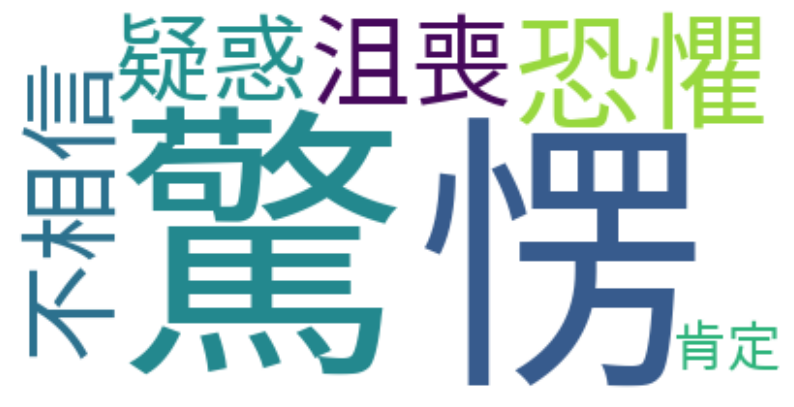

In [35]:
# 設定 WordCloud 參數，例如字體、背景顏色等
# 如果需要顯示中文，請指定中文字體
# 參照https://colab.research.google.com/github/willismax/matplotlib_show_chinese_in_colab/blob/master/matplotlib_show_chinese_in_colab.ipynb#scrollTo=AByB62T315mR
# 使用TaipeiSans
wordcloud = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white').generate(response_wo_ana.choices[0].message.content)

# 顯示文字雲
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

依照文字出現頻率而繪製的文字雲

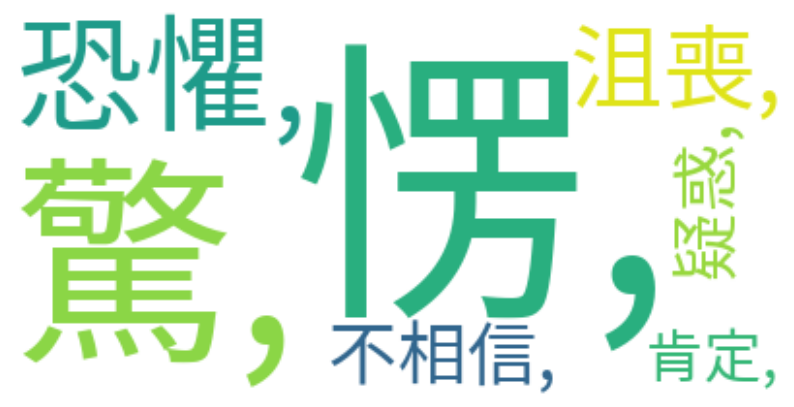

In [42]:
# 從頻率字典產生文字雲
wordcloud_fre = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white')
wordcloud_fre.generate_from_frequencies(emopatient)

# 顯示文字雲
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_fre, interpolation='bilinear')
plt.axis('off')
plt.show()

## 1.5. 情緒分類

使用NTUSD辭典，發現並不能有效區別日記中的情緒，故採用皮克斯電影中「腦筋急轉彎」中，情緒角色，作為分類的依據

In [60]:
emotion_dict = {
    "快樂": [
        "開心", "快樂", "高興", "喜悅", "幸福", "滿足", "爽快", "愉快", "輕鬆", "欣慰",
        "舒服", "激動", "興奮", "雀躍", "開懷", "如釋重負", "安心", "欣喜", "甜蜜", "幸福感"
    ],
    "焦慮": [
        "焦慮", "不安", "緊張", "擔心", "煩躁", "惶恐", "坐立難安", "心神不寧", "心慌",
        "忐忑", "惴惴", "沒安全感", "提心吊膽", "急躁", "煩悶", "無措", "亂", "懷疑", "恐慌", "心煩"
    ],
    "討厭": [
        "討厭", "厭惡", "排斥", "嫌棄", "反感", "膩", "煩", "受不了", "厭煩", "嫌",
        "刺眼", "刺耳", "懶得理", "懶得看", "不想理", "懷疑", "抗拒", "否定", "看不順眼", "不耐煩"
    ],
    "憤怒": [
        "生氣", "憤怒", "怒火", "氣憤", "氣死", "發火", "火大", "抓狂", "咬牙", "怒氣沖天",
        "怒目", "怒吼", "冒火", "氣炸", "惱怒", "不爽", "發飆", "氣到哭", "氣到笑", "動怒"
    ],
    "憂鬱": [
        "憂鬱", "悲傷", "難過", "沮喪", "失落", "空虛", "低落", "無助", "孤單", "痛苦",
        "不想活", "想哭", "沉重", "壓抑", "疲憊", "崩潰", "麻木", "悶", "失望", "黑暗"
    ],
    "驚恐": [
        "害怕", "恐懼", "驚嚇", "驚恐", "心驚膽跳", "受驚", "緊張兮兮", "慌張", "不知所措", "發抖",
        "恐慌", "戰慄", "魂飛魄散", "慌亂", "怕死", "不寒而慄", "倒抽一口氣", "心跳加速", "冒冷汗", "驚慌失措"
    ],
    "羨慕": [
        "羨慕", "嫉妒", "眼紅", "酸", "忌妒", "心酸", "想要", "羨慕不已", "好羨慕", "羨慕得要命",
        "羨慕他人", "羨慕自己沒有", "怨", "羨望", "眼饞", "欣羨", "仰慕", "欽佩", "欽羨", "失落地看著"
    ],
    "無所謂": [
        "無所謂", "隨便", "沒差", "無感", "無聊", "懶得管", "不在意", "冷淡", "不關心", "冷漠",
        "看開", "不放在心上", "心如止水", "不在乎", "覺得無趣", "沒興趣", "被動", "沒感覺", "已經習慣", "沒什麼好說"
    ],
    "害羞": [
        "害羞", "不好意思", "臉紅", "怕見人", "低頭", "不敢說", "不敢看", "緊張", "羞澀", "羞愧",
        "怕被笑", "躲避", "閃躲", "遮掩", "不自在", "小聲說", "結巴", "慌張", "手足無措", "拘謹"
    ]
}

In [52]:
type(emotion_dict)
emotion_dict.get("羨慕",0)

['羨慕',
 '嫉妒',
 '眼紅',
 '酸',
 '忌妒',
 '心酸',
 '想要',
 '羨慕不已',
 '好羨慕',
 '羨慕得要命',
 '羨慕他人',
 '羨慕自己沒有',
 '怨',
 '羨望',
 '眼饞',
 '欣羨',
 '仰慕',
 '欽佩',
 '欽羨']

分割情緒字典的dictionary

In [53]:
items = emotion_dict.items()

for key, value in items:
  emo = key
  print(key, value)
#  print(emo)

快樂 ['開心', '快樂', '高興', '喜悅', '幸福', '滿足', '爽快', '愉快', '輕鬆', '欣慰', '舒服', '激動', '興奮', '雀躍', '開懷', '如釋重負', '安心', '欣喜', '甜蜜', '幸福感']
焦慮 ['焦慮', '不安', '緊張', '擔心', '煩躁', '惶恐', '坐立難安', '心神不寧', '心慌', '忐忑', '惴惴', '沒安全感', '提心吊膽', '急躁', '煩悶', '無措', '亂', '懷疑', '恐慌', '心煩']
討厭 ['討厭', '厭惡', '排斥', '嫌棄', '反感', '膩', '煩', '受不了', '厭煩', '嫌', '刺眼', '刺耳', '懶得理', '懶得看', '不想理', '懷疑', '抗拒', '否定', '看不順眼', '不耐煩']
憤怒 ['生氣', '憤怒', '怒火', '氣憤', '氣死', '發火', '火大', '抓狂', '咬牙', '怒氣沖天', '怒目', '怒吼', '冒火', '氣炸', '惱怒', '不爽', '發飆', '氣到哭', '氣到笑', '動怒']
憂鬱 ['憂鬱', '悲傷', '難過', '沮喪', '失落', '空虛', '低落', '無助', '孤單', '痛苦', '不想活', '想哭', '沉重', '壓抑', '疲憊', '崩潰', '麻木', '悶', '失望', '黑暗']
驚恐 ['害怕', '恐懼', '驚嚇', '驚恐', '心驚膽跳', '受驚', '緊張兮兮', '慌張', '不知所措', '發抖', '恐慌', '戰慄', '魂飛魄散', '慌亂', '怕死', '不寒而慄', '倒抽一口氣', '心跳加速', '冒冷汗', '驚慌失措']
羨慕 ['羨慕', '嫉妒', '眼紅', '酸', '忌妒', '心酸', '想要', '羨慕不已', '好羨慕', '羨慕得要命', '羨慕他人', '羨慕自己沒有', '怨', '羨望', '眼饞', '欣羨', '仰慕', '欽佩', '欽羨']
無所謂 ['無所謂', '隨便', '沒差', '無感', '無聊', '懶得管', '不在意', '冷淡', '不關心', '冷漠', '看開', '不放在心上', '心如止水', 

測試模糊比對

In [54]:
process.extract("驚恐", emotion_dict.get("驚恐",0))

[('驚恐', 100), ('恐懼', 50), ('驚嚇', 50), ('受驚', 50), ('恐慌', 50)]

### 1.5.1. 分類AI agent的情緒

In [57]:
sum = 0
emo_list ={}
emo_frame = pd.DataFrame()

# 讀取AI agent分析的所有字詞
for key, value in emopatient.items():
  # 依據情緒辭典的7個類別
  for emo in emotion_dict.keys():
    # 依依模糊比對
    results = process.extract(key, emotion_dict.get(emo,0))
#    print(results)
    # 加總該詞組內，最相近的4個詞的相似性總分
    for result in results:
      sum = sum + result[1]
#    print(sum)
    # 輸出成dict
    emo_list.update({emo: sum})
    sum = 0
#  print(emo_list)
  # 將dict轉成dataframe
  emo_frame = pd.concat([emo_frame, pd.DataFrame([emo_list])], ignore_index=True)
  emo_list = {}
print(emo_frame)

   快樂   焦慮   討厭  憤怒   憂鬱   驚恐  羨慕  無所謂   害羞
0   0    0    0   0    0    0   0    0    0
1   0    0    0   0    0  450   0    0    0
2   0  100    0   0    0  200   0    0    0
3   0    0    0   0  100    0   0    0    0
4   0   74  128  45   33   58  29  129  128
5   0   50   50   0    0    0   0    0    0
6   0    0   50   0    0    0   0    0    0


### 1.5.2. 加總所有情緒詞在9個類別的總分

In [58]:
emotion = emo_frame.sum().sort_values(ascending=False)
print(emotion)

驚恐     708
討厭     228
焦慮     224
憂鬱     133
無所謂    129
害羞     128
憤怒      45
羨慕      29
快樂       0
dtype: int64


### 1.5.3. 繪製9個情緒類別的文字雲

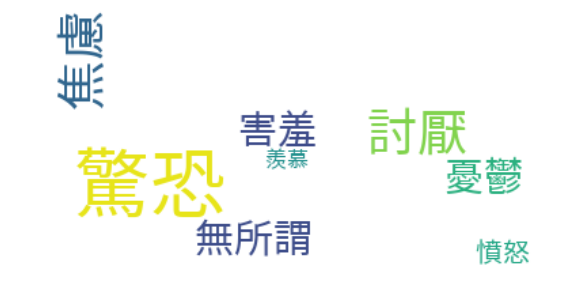

In [59]:
# 從頻率字典產生文字雲
wordcloud_tot = WordCloud(font_path='TaipeiSansTCBeta-Regular.ttf',
                      background_color='white')
wordcloud_tot.generate_from_frequencies(emotion)

# 顯示文字雲
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud_tot, interpolation='bilinear')
plt.axis('off')
plt.show()

## 1.6. 建立Web

建立AI agent

In [ ]:
def chat_with_rag(user_input):
    # 將自定 prompt 套入格式
    final_prompt = mixed_prompt.format(retrieved_chunks_post=retrieved_pos_chunks,
                                       retrieved_chunks_neg=retrieved_neg_chunks,
                                       question=user_input)

    # 呼叫 OpenAI API
    response_ana = client.chat.completions.create(
      model=model,
      messages=[
        {"role": "system", "content": mixed_prompt},
        {"role": "user", "content": final_prompt},
      ]
    )

    chat_history.append((user_input, answer))
    return answer